# Keep it simple s...

## Imports

In [26]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter
from modules.negative_set import generate_negative_set, get_box_parameters
from modules import data, models, descriptor_vector, validation, selection
from modules.selection import try_classifiers, try_params
from modules.window import compute_no_windows
import numpy as np
from skimage.transform import resize
from skimage.color import rgb2gray
import pickle
from pprint import pprint as pp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Store
store = []

In [6]:
# Load data directly
GRAY = True
OFFSET = 0
LIMIT = None

full_images = images = data.load_images(limit=LIMIT, offset=OFFSET, gray=GRAY)
full_labels = labels = data.load_labels(limit=LIMIT, offset=OFFSET)
print(f"Using {len(images)}/1000 images & {len(labels)}/1284 labels")

Using 1000/1000 images & 1284/1284 labels


In [125]:
# Limit if needed
LIMIT = 300
if LIMIT:
   images = full_images[OFFSET:OFFSET+LIMIT]
   labels = full_labels[full_labels[:,0] <= OFFSET+LIMIT]
   labels = labels[labels[:,0] > OFFSET]
else:
   images = full_images
   labels = full_labels
print(len(images))
#if GRAY:
#    images = np.array([ rgb2gray(img) for img in images ])

300


## Params

In [126]:
# Global params
only_one_training = False
limit_score = 0.5
slide_step = (60,50)
downscale_step = 30
box_size = (150, 90)

# Model
CLASSIFIER = 'random_forest'
MODEL_PARAMS = {
    'n_estimators': 100,
#    'max_depth': None,
#    'max_features': 100,
    'class_weight': { -1: 1, 1: 1}
}
VECTORIZATION_PARAMS = {
    'vectorize': descriptor_vector.daisy,
#    'vectorize_kwargs': [6],
} 

## Adapt data

In [127]:
# Label sets
NEG_SIZE = 4000
NEG_SUP = 10000
TRAIN_RATE = 0.75

print(f"Using {len(images)}/1000 images & {len(labels)}/1284 labels")
print(f"Generating {NEG_SIZE} negatives...")
negatives = generate_negative_set(images, labels, set_size=NEG_SIZE)

print("Creating train & validation sets with negatives...")
all_labels = np.concatenate([labels, negatives])
train_labels, valid_labels = data.train_valid_sets(len(images), all_labels, TRAIN_RATE)

# Validation with additional negatives
pvalid_labels = np.concatenate([ valid_labels, generate_negative_set(images, labels, set_size=NEG_SIZE) ])
label_sets = train_labels, pvalid_labels

print(f"Train: {len(np.unique(train_labels[:,0]))}, Valid: {len(np.unique(valid_labels[:,0]))}")
print(Counter(train_labels[:,5]), Counter(valid_labels[:,5]))

Using 300/1000 images & 401/1284 labels
Generating 4000 negatives...
Creating train & validation sets with negatives...
Train: 225, Valid: 75
Counter({-1: 3015, 1: 300}) Counter({-1: 985, 1: 101})


---

## Now Try !

### 1. Main Single

In [ ]:
# ( 1 ) --- Single --- Train, predict, validate
clf = models.create_model(CLASSIFIER, MODEL_PARAMS)
kwargs = { 'limit_score': limit_score, 'slide_step': slide_step, 'downscale_step': downscale_step }

print("Training...")
train_results = models.train(clf, images, box_size, train_labels, **VECTORIZATION_PARAMS,
                             only_one_training=only_one_training, **kwargs)

In [39]:
# Predictions
print("Predicting with windows...")
valid_indexes = np.unique(valid_labels[:,0]) - 1
predictions, scores = models.predict(clf, images, box_size, **VECTORIZATION_PARAMS,
                                     only=valid_indexes, with_scores=True,**kwargs)

results = validation.rate_predictions(predictions, valid_labels)
print("Done")

print("\n------\n")
if results not in store: store.append(results)
pp(results)

Predict with additional negatives...
{'avg_precision': 0.8337286944298015,
 'f1-score': 0.9019607843137255,
 'precision': array([0.06888069, 1.        , 1.        ]),
 'recall': array([1.        , 0.82142857, 0.        ]),
 'roc_auc_score': 0.9107142857142857}


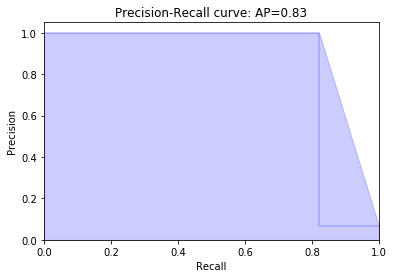

In [54]:
# Validation with additional negatives
NEG_SUP = 10000
pvalid_labels = np.concatenate([ valid_labels, generate_negative_set(images, labels, set_size=NEG_SIZE) ])

print("Predict with additional negatives...")
pvalid_indexes = np.unique(valid_labels[:,0]) - 1
scores, results = models.predict_and_validate(clf, images, box_size, pvalid_labels,
                                              **VECTORIZATION_PARAMS, only=pvalid_indexes,**kwargs)
pp(results)

### 2. Multiple Parameters

In [128]:
# ( 2 ) --- Multiple --- Try multiple params
clf_name = 'random_forest'
global_params = {
    # General
    'box_size': (150, 90),

    'n_estimators': 200,
#     'C': 0.75,
#     'max_iter': 1000,
    
    'vectorization_params': {
        'vectorize': descriptor_vector.hog,
#        'vectorize_kwargs': { 'orientations': 6},
    },
}

kw_params = {
    'limit_score': 0.5,
    'slide_step': (60,50),
    'downscale_step': 30,
    'only_one_training': False,
}

changing_params = {
    'vectorization_params': [
        {
            'vectorize': descriptor_vector.daisy,
            'vectorize_kwargs': { 'radius': 5 },
        }, 
        { 'vectorize': descriptor_vector.hog }, 
#        { 'vectorize': descriptor_vector.haar }, 
    ]
}

print(f"Using {len(images)} images")
results = try_params(images, (train_labels, pvalid_labels), clf_name, global_params, changing_params, **kw_params)

print("\n------\n")
if results not in store: store.append(results)
pp(results)

Using 300 images
## Trying parameter `vectorization_params`...
### with value `{'vectorize': <function daisy at 0x000001AD37F11400>, 'vectorize_kwargs': {'radius': 5}}`
Vectorizing data...
First training with (3315, 8, 4, 200) rows...


ValueError: Found array with dim 4. Estimator expected <= 2.

### 3. Multiple Classifiers

Using 300 images

# Trying classifier `svc`...
Vectorizing data...
First training with (3308, 243) rows...



Adding 3 false positives / 70 predictions
Vectorizing data...
Second training with (3311, 243) rows...


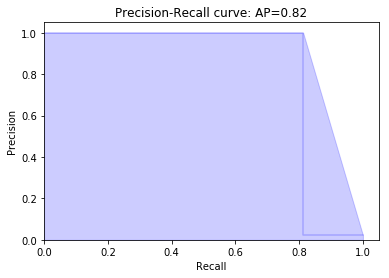


# Trying classifier `linear_svc`...
Vectorizing data...
First training with (3308, 243) rows...



Adding 87 false positives / 242 predictions
Vectorizing data...
Second training with (3395, 243) rows...


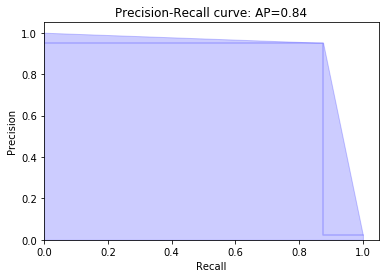


# Trying classifier `adaboost`...
Vectorizing data...
First training with (3308, 243) rows...



!! No false positives given out of 12 predictions, add more images or reduce negatives
Adding 0 false positives / 12 predictions
Vectorizing data...
Second training with (3308, 243) rows...


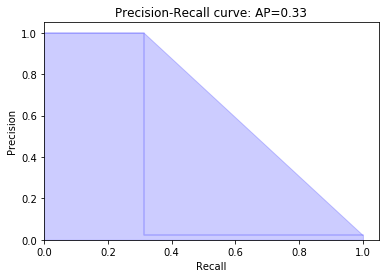


# Trying classifier `random_forest`...
Vectorizing data...
First training with (3308, 243) rows...



Adding 6 false positives / 51 predictions
Vectorizing data...
Second training with (3314, 243) rows...


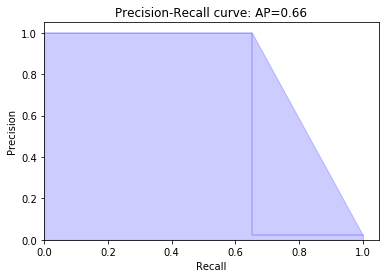


------

{'adaboost': {'classifier': 'adaboost',
              'global_params': {'base_estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
                                'box_size': (150, 90),
                                'vectorization_params': {'vectorize': <function hog at 0x000001AD36D93C80>}},
              'results': [{'result': {'avg_precision': 0.32761879049676024,
                                      'f1-score': 0.47619047619047616,
                                      'false_neg': 77,
                                      'false_pos': 0,
                                      'n_test': 5093,
   

In [36]:
# ( 3 ) --- Multiple --- Try multiple classifiers
common_params = {
    # General
    'box_size': (150, 90),
    'vectorization_params': {
        'vectorize': descriptor_vector.hog,
#        'vectorize_kwargs': { 'orientations': 6},
    },
}

kw_params = {
    'limit_score': 0.5,
    'slide_step': (60,50),
    'downscale_step': 30,
    'only_one_training': False,
}

global_params = {
    'svc': {
        **common_params,
        'gamma': 'scale',
    },
    'linear_svc': {
        **common_params,
    },
    'decision_tree': {
        **common_params,
    },
    'adaboost': {
        **common_params,
        'base_estimator': models.create_model('random_forest', { 'n_estimators': 10, 'max_depth': 30 })
    },
    'random_forest': {
        **common_params,
        'n_estimators': 100,
    },
}

changing_params = {
}

only_clf = ('svc', 'adaboost', 'linear_svc', 'random_forest')
global_params = { key: value for key, value in global_params.items() if key in only_clf }

print(f"Using {len(images)} images")
results = try_classifiers(images, label_sets, global_params, changing_params, **kw_params)

print("\n------\n")
pp(results)

-----
-----
-----

### 4. Test predictions

In [122]:
# Import predictions
from modules.window import show_boxes
from config import PREDICTION_PATH, GRAY, TEST_LIMIT, VERSION

test_images = data.load_images('test', limit=None)
test_labels = data.load_labels(path=PREDICTION_PATH)[:,:6]
print(f"Got {len(test_labels)} predictions")

Got 305 predictions


In [123]:
# Display predictions on each image and save it
from collections import Counter
#print(Counter(test_labels[:,0]))
show_boxes(test_images, test_labels, only=None, display=False, save=True, path=f"detected/{1}")

### 5. Tests

In [ ]:
# ( 5 ) --- Haar features optimized
int_images = descriptor_vector.compute_integral_images(images)


In [25]:
from skimage.feature import haar_like_feature, haar_like_feature_coord
slide_step = (10, 10)
box_size = (30, 30)
feature_type = 'type-3-x'

iimg = int_images[0]
h, l = iimg.shape[:2]

ft_coord, ft_type = haar_like_feature_coord(*box_size[::-1], feature_type=feature_type)
ft_rate = 0.7
n_features = int(ft_coord.shape[0] * ft_rate)

print(compute_no_windows(iimg, box_size, slide_step, downscale_step))
print(ft_coord.shape[0])

8743
67280


In [20]:
def compute_haar(iimg, ft_set, box_size, slide_step, downscale_step):
    assert all([ len(x) == 2 for x in (ft_set, slide_step, box_size)])
    ft_coord, ft_type = ft_set
    slide_h, slide_l = slide_step
    box_h, box_l = box_size
    
    n_windows = compute_no_windows(iimg, box_size, slide_step, downscale_step)
    n_features = ft_coord.shape[0]

    features = np.empty((, n_features))
    for x in range(0, h - box_h, slide_h):
        for y in range(0, l - box_l, slide_l):
            ft = haar_like_feature(iimg, x, y, *box_size[::-1], feature_type=ft_type, feature_coord=ft_coord)
            r.append(ft)
        break

    return features

(42, 67280)
[[-4.76427451e-01 -9.58526275e-01 -1.40833608e+00 ... -1.14430980e-01
  -1.02941176e-01 -1.04347843e-01]
 [-5.26036745e+00 -5.65385373e+00 -5.88058431e+00 ... -9.26435294e-02
  -9.65650980e-02 -9.26435294e-02]
 [-8.54944745e+00 -8.72380314e+00 -8.85191059e+00 ... -9.65650980e-02
  -9.34541176e-02 -9.65650980e-02]
 ...
 [-1.46704142e+02 -1.47185064e+02 -1.47689516e+02 ... -5.48482745e-01
  -5.41747843e-01 -5.37826275e-01]
 [-1.51608354e+02 -1.52125441e+02 -1.52634685e+02 ... -5.26061569e-01
  -5.26061569e-01 -5.26061569e-01]
 [-1.56751777e+02 -1.57288473e+02 -1.57823592e+02 ... -5.17087451e-01
  -5.17087451e-01 -5.17087451e-01]]


In [ ]:
# Display false_positives
from skimage.io import imshow_collection
imgs = []
for falpos in train_results:
    img_id = falpos[0]
    x,y,h,l = falpos[1:5]
    img = images[img_id-1]
    imgs.append(img[x:x+h,y:y+l])
imshow_collection(imgs)